In [33]:
from pycolab import ascii_art
from pycolab.prefab_parts import sprites as prefab_sprites
from pycolab.rendering import ObservationToFeatureArray

import os
import numpy as np
import pycolab

from tqdm import tqdm
from collections import namedtuple

from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

# Introduction

TODO

# Implementations

TODO

### Environments

#### 1. Blocking Maze

In [34]:
BLOCKING_MAZE = [
    ['###########',
     '#         #',
     '#         #',
     '#         #',
     '######### #',
     '#         #',
     '#         #',
     '###########'],
    ['###########',
     '#         #',
     '#         #',
     '#         #',
     '# #########',
     '#         #',
     '#         #',
     '###########']
]

#### 2. Shortcut Maze

In [35]:
SHORTCUT_MAZE = [
    ['###########',
     '#         #',
     '#         #',
     '#         #',
     '# #########',
     '#         #',
     '#         #',
     '###########'],
    ['###########',
     '#         #',
     '#         #',
     '#         #',
     '# ####### #',
     '#         #',
     '#         #',
     '###########']
]

#### 3. Environment Mechanics

In [36]:
def make_game(art):
    """Builds and returns game."""
    return ascii_art.ascii_art_to_game(art, what_lies_beneath=' ', sprites={'P': PlayerSprite})

class PlayerSprite(prefab_sprites.MazeWalker):
    """A `Sprite` for our player.
    This `Sprite` ties actions to going in the four cardinal directions. If we
    reach a magical location, the agent receives a reward of 1 and the epsiode terminates.
    """

    def __init__(self, corner, position, character):
        """Inform superclass that the '#' delimits the walls."""
        super(PlayerSprite, self).__init__(corner, position, character, impassable='#')
    


    def update(self, actions, board, layers, backdrop, things, the_plot):
        del backdrop, things   # Unused in this application.

        # Apply motion commands.
        if actions == 0:    # walk upward
            self._north(board, the_plot)
        elif actions == 1:  # walk downward
            self._south(board, the_plot)
        elif actions == 2:  # walk leftward
            self._west(board, the_plot)
        elif actions == 3:  # walk rightward
            self._east(board, the_plot)

        # See if our agent is on the goal position
        if layers["G"][self.position]:
            the_plot.add_reward(1.0)
            the_plot.terminate_episode()
        else:
            the_plot.add_reward(0.0)

In [37]:
class Maze(object):
    def __init__(self, arts, start, goal):
        self.arts = arts
        self.index = 0
        
        self.START = start
        self.GOAL  = goal
    
    def _add_marker(self, art, marker, position):
        y, x = position
        tmp = list(art[y])
        tmp[x] = marker
        art[y] = "".join(tmp)
        return art
    
    def build(self):
        art = self.arts[self.index]
        art = self._add_marker(art, "P", self.START)  # add the player's position
        art = self._add_marker(art, "G", self.GOAL)  # add the goal's position
        self.game = make_game(art)
        return self
    
    def select(self, i):
        assert i < len(self.arts), "Index out of bounds. Should be between {} and {}".format(0, len(self.arts)-1)
        self.index = i
        return self
    
    def its_showtime(self):
        obs, reward, gamma = self.game.its_showtime()
        return obs, reward, gamma
    
    def play(self, action):
        obs, reward, gamma = self.game.play(action)
        return obs, reward, gamma
    
    @property
    def rows(self):
        return self.game.rows
    
    @property
    def cols(self):
        return self.game.cols
    
    @property
    def game_over(self):
        return self.game.game_over

In [73]:
class Recorder(object):
    def __init__(self, save_dir, obs, Q):
        
        self.save_dir = save_dir
        if not(os.path.exists(self.save_dir)):
            os.makedirs(self.save_dir)
        
        self.fig, self.ax = plt.subplots(1, 2, figsize=(2, 4))
        self.ax[0].axis("off")
        self.ax[1].axis("off")
        
        
        board = 80 * np.array(obs.layers['P'], dtype=np.float)
        board += 15 * np.array(obs.layers['#'], dtype=np.float)
        board += 50 * np.array(obs.layers['G'], dtype=np.float)
        self.im1 = self.ax[0].imshow(board)
        
        V = 255 * np.max(Q, axis=2)
        V = V.astype(np.int)
        self.im2 = self.ax[1].imshow(V)
        self.im2.set_cmap("inferno")
        
        
        
    def save_img(self, obs, Q, step):
        
        board = 80 * np.array(obs.layers['P'], dtype=np.float)
        board += 15 * np.array(obs.layers['#'], dtype=np.float)
        board += 50 * np.array(obs.layers['G'], dtype=np.float)
        
        V = 255 * np.max(Q, axis=2)
        V = V.astype(np.int)
        
        self.im1.set_data(board)
        self.im2.set_data(V)
        self.im2.set_clim(vmin=V.min(), vmax=V.max())
        
        self.fig.savefig(plt.savefig(os.path.join(self.save_dir, "img_{}.png".format(step)), bbox_inches='tight'))

### Dyna-Q Algorithm

In [74]:
class SimpleModel(object):
    def __init__(self):
        """
        self._mapping: maps previously seen state_action_pairs to their next_state and reward 
        """
        self._mapping = dict()
    
    def add_transition(self, state, action, next_state, reward):
        """
        sate: list of int coordinates [x, y]
        action: int
        next_state: list of int coordinates [x, y]
        reward: float
        """
        # If state has never been visited, it is added to the model
        if state not in self._mapping.keys():
            self._mapping[state] = dict()
        
        # Adds the reward and next_state resulting from state_action_pair to the model
        self._mapping[state][action] = (reward, next_state)
    
    def sample(self):
        """
        return: sampled state-action pair with their corresponding next_state and reward
        """
        # Samples a state among the previously visited states
        state_index = np.random.choice(range(0, len(self._mapping.keys())))
        sampled_state = list(self._mapping)[state_index]
        
        # Samples an action among the previously selected actions for the sampled_state
        action_index = np.random.choice(range(0, len(self._mapping[sampled_state].keys())))
        sampled_action = list(self._mapping[sampled_state])[action_index]
        
        # extracts the reward and next_state for the sampled state-action pair
        sampled_reward, sampled_next_state = self._mapping[sampled_state][sampled_action]
        
        return sampled_state, sampled_action, sampled_reward, sampled_next_state

In [79]:
class DynaQ(object):
    def __init__(self, gamma=0.95, epsilon=0.1, alpha=0.1, n_planning_steps=5, threshold=0.01):
        # discount factor
        self.gamma = gamma

        # probability for exploration
        self.epsilon = epsilon

        # step size
        self.alpha = alpha

        # n-step planning
        self.n_planning_steps = n_planning_steps
        
        # threshold to consider a state-action pair value as being better than another one
        self.threshold = threshold
        
    # action selection with epsilon-greedy scheme
    def _select_action(self, state, Q):
        
        # flips a coin with probability epsilon to have 1 ...
        if np.random.binomial(1, self.epsilon) == 1:
            # if it's the case randomly pick an action amongst ALL ACTIONS. (EXPLRATION)
            return np.random.randint(4)
        
        else:
            # otherwise, pick an action (at random) amongst ACTIONS NEAR MAXIMUM VALUE (if many) (EXPLOITATION)
            values = Q[state[0], state[1], :]
            return np.random.choice(np.where((np.max(values) - values) < self.threshold)[0])

    # tabular dyna-Q algorithm
    def apply(self, Q, model, game, global_steps, n_steps, record=False):
        
        # initializes the game object
        obs, reward, gamma = game.its_showtime()
        del gamma #unused
        
        # finds where our agent is on the map, this position is the agent's current_state
        position = np.array(obs.layers['P'])
        current_state = np.unravel_index(position.argmax(), position.shape)
        
        steps = 0
        
        if record:
            recorder = Recorder("imgs", obs, Q)
            current_global_step = global_steps + steps
            recorder.save_img(obs, Q, current_global_step)

        while not(game.game_over):

            steps += 1

            # chooses an action to execute according to epsilon-greedy scheme
            action = self._select_action(current_state, Q)

            # takes action (samples a next state and reward form the environment)
            obs, reward, gamma = game.play(action)
            del gamma # unused
            
            # finds where our agent is after having taken action, this position is the next_state
            position = np.array(obs.layers['P'])
            next_state = np.unravel_index(position.argmax(), position.shape)
            
            if record:
                current_global_step = global_steps + steps
                recorder.save_img(obs, Q, current_global_step)

            # Q-Learning update (with real experience)
            Q[current_state[0], current_state[1], action] += \
                self.alpha * (reward + self.gamma * np.max(Q[next_state[0], next_state[1], :]) -
                Q[current_state[0], current_state[1], action])

            # feed the model with experience (adds new newly discovered transition)
            model.add_transition(current_state, action, next_state, reward)

            # random sample n-step tabular Q-planning
            for t in range(self.n_planning_steps):
                sampled_state, sampled_action, sampled_reward, sampled_next_state = model.sample()
                
                # Q-Learning update (with simulated experience)
                Q[sampled_state[0], sampled_state[1], sampled_action] += \
                    self.alpha * (sampled_reward + self.gamma * np.max(Q[sampled_next_state[0], sampled_next_state[1], :]) -
                    Q[sampled_state[0], sampled_state[1], sampled_action])

            # updates the current_state
            current_state = next_state
            
            if steps > n_steps:
                break
                
        if record:
            plt.close(recorder.fig)
        
        return steps

### Changing Maze scenario

In [80]:
def changing_maze_experiment(maze_arts, params):

    # set up max steps
    n_steps = params.n_steps

    # track the cumulative rewards
    rewards = np.zeros((n_steps,))

    for run in tqdm(range(0, params.n_runs)):
        
        # instantiate dyna-Q algorithm
        agent = DynaQ(gamma=0.95, epsilon=0.1, alpha=params.alpha, n_planning_steps=5)
        
        # set up model
        model = SimpleModel()

        # track cumulative reward in current run
        rewards_ = np.zeros((n_steps,))
        
        # instantiate game
        maze = Maze(maze_arts, start=(6, 4), goal=(1, 9))
        game = maze.select(0).build()
        index = game.index

        # initialize state action values
        state_action_values = np.zeros((game.rows, game.cols, 4))

        steps = 0
        last_steps = steps
        while steps < n_steps:
            # play for an episode
            steps += agent.apply(state_action_values, model, game, steps, n_steps, params.record)

            # update cumulative rewards
            steps_ = min(steps, n_steps - 1)
            rewards_[last_steps : steps_] = rewards_[last_steps]
            rewards_[steps_] = rewards_[last_steps] + 1
            last_steps = steps
            
            
            if index < len(params.change_points) and steps > params.change_points[index]:
                # change maze
                game = maze.select(1).build()
                index = game.index
            else:
                # keep same maze (rebuild)                
                game = maze.select(0).build()
                index = game.index
        rewards += rewards_

    # averaging over runs
    rewards /= params.n_runs

    return rewards

# Experiments

### 3. Demo episode

In [82]:
# parameters for experiments
Params = namedtuple("Params", ["n_steps", "n_runs", "change_points", "alpha", "record"])
params = Params(n_steps=3000, n_runs=1, change_points=[1000, np.inf], alpha=0.5, record=True)

# run the experiments on both "blocking maze" and "shortcut maze"
np.random.seed(1234)
rewards_bm = changing_maze_experiment(BLOCKING_MAZE, params)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:49<00:00, 109.73s/it]


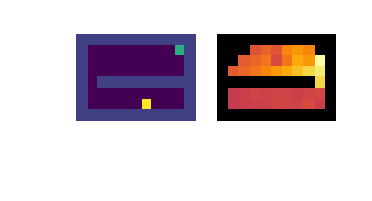

In [85]:
all_images = sorted(os.listdir("imgs"))
all_images_list = []

fig = plt.figure()

for image in all_images[:300]:
    
    im = plt.imread(os.path.join("imgs", image))
    anim_im = plt.imshow(im, animated=True)
    plt.axis('off')
    all_images_list.append([anim_im])

ani = animation.ArtistAnimation(fig, all_images_list, interval=50, blit=True, repeat_delay=1000)

HTML(ani.to_html5_video())

### 2. Dyna-Q in Blocking Maze and Shortcut Maze

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


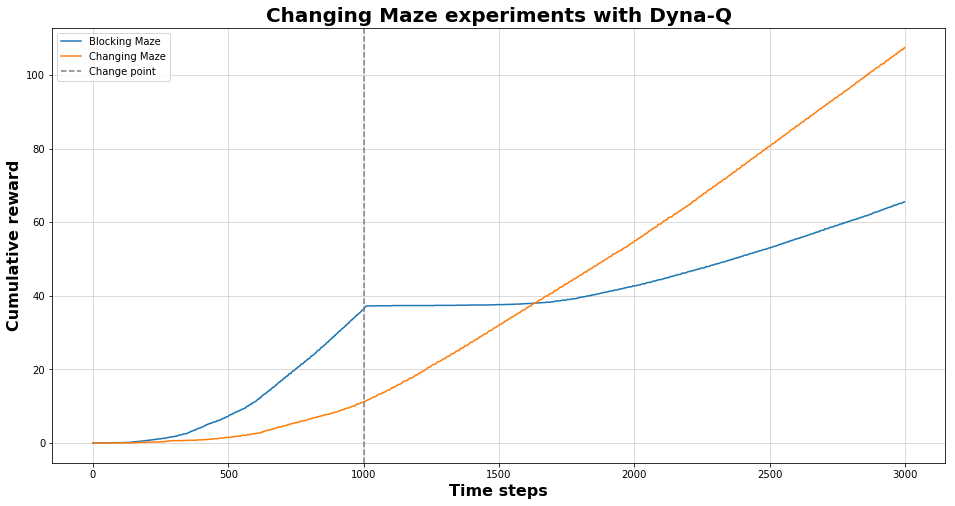

In [32]:
# parameters for experiments
Params = namedtuple("Params", ["n_steps", "n_runs", "change_points", "alpha", "record"])
params = Params(n_steps=3000, n_runs=20, change_points=[1000, np.inf], alpha=0.5, record=False)

# run the experiments on both "blocking maze" and "shortcut maze"
rewards_bm = changing_maze_experiment(BLOCKING_MAZE, params)
rewards_sm = changing_maze_experiment(SHORTCUT_MAZE, params)

# plot results
plt.figure(figsize=(16, 8))
plt.plot(rewards_bm[:-1], label="Blocking Maze")
plt.plot(rewards_sm[:-1], label="Changing Maze")
plt.axvline(params.change_points[0], color="gray", linestyle="--", label="Change point")
plt.title('Changing Maze experiments with Dyna-Q', fontsize=20, fontweight='bold')
plt.xlabel('Time steps', fontsize=16, fontweight='bold')
plt.ylabel('Cumulative reward', fontsize=16, fontweight='bold')
plt.legend(loc="best")
plt.grid(True, color="lightgrey")
plt.show()

### 3. Dyna-Q in Blocking Maze for different learning rate $\alpha$

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:42<00:00,  1.17it/s]


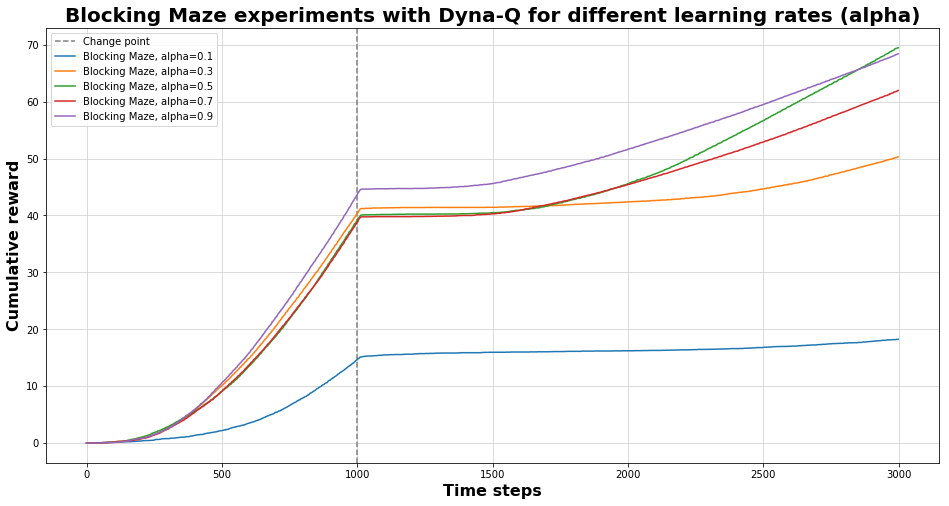

In [31]:
plt.figure(figsize=(16, 8))
plt.axvline(params.change_points[0], color="gray", linestyle="--", label="Change point")

for current_alpha in [0.1, 0.3, 0.5, 0.7, 0.9]:

    np.random.seed(1234)
    # parameters for experiments
    Params = namedtuple("Params", ["n_steps", "n_runs", "change_points", "alpha", "record"])
    params = Params(n_steps=3000, n_runs=50, change_points=[1000, np.inf], alpha=current_alpha, record=False)

    # run the experiments on both "blocking maze" and "shortcut maze"
    rewards_bm = changing_maze_experiment(BLOCKING_MAZE, params)

    # plot results
    plt.plot(rewards_bm[:-1], label="Blocking Maze, alpha={}".format(current_alpha))
    plt.title('Blocking Maze experiments with Dyna-Q for different learning rates (alpha)', fontsize=20, fontweight='bold')
    plt.xlabel('Time steps', fontsize=16, fontweight='bold')
    plt.ylabel('Cumulative reward', fontsize=16, fontweight='bold')
    plt.legend(loc="best")
    plt.grid(True, color="lightgrey")

plt.show()

In [ ]:
def show(obs):
    self.obs = obs
    board = 80 * np.array(obs.layers['P'], dtype=np.float)
    board += 15 * np.array(obs.layers['#'], dtype=np.float)
    board += 50 * np.array(obs.layers['G'], dtype=np.float)

    self.test = _board

    if self.i1 == 0:
        self.p1 = self.ax[0].imshow(_board)
    else:
        self.p1.set_data(_board)

    self.i1 += 1

    plt.axis('off')
    #plt.pause(self.delay)

def show_VF(self, Q):

    _V = 255 * np.max(Q, axis=2)
    _V = _V.astype(np.int)

    if self.i2 == 0:
        self.p2 = self.ax[1].imshow(_V)
        self.p2.set_cmap("inferno")
    else:
        self.p2.set_data(_V)
        self.p2.set_clim(vmin=_V.min(), vmax=_V.max())

    self.i2 += 1

    plt.axis('off')
    plt.pause(self.delay)

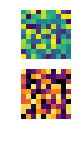

In [12]:
import time
fig, ax = plt.subplots(2, 1, figsize=(4, 2))
ax[0].axis("off")
ax[1].axis("off")

# For the board
board = np.random.randint(low=0, high=255, size=(10,10))

im1 = ax[0].imshow(board)

# For the State Value function (V)
V = np.random.randint(low=0, high=255, size=(10,10))

im2 = ax[1].imshow(V)
im2.set_cmap("inferno")

for i in range(10):
    
    im1.set_data(np.random.randint(low=0, high=255, size=(10,10)))
    plt.show()

# How dows Dyna-Q relate to Experience Replay ?

# Conclusion